In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import os
import numpy as np
from PIL import Image

# Configuration
IMG_HEIGHT = 1024
IMG_WIDTH = 1024
BATCH_SIZE = 4
EPOCHS = 200
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data paths
DAY_PATH = '/content/dataset/day'
NIGHT_PATH = '/content/dataset/night'

# Image transformations
transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load datasets
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_paths = [os.path.join(root_dir, fname) for fname in os.listdir(root_dir) if fname.endswith(('png', 'jpg', 'jpeg'))]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

# Load datasets
day_dataset = ImageDataset(root_dir=DAY_PATH, transform=transform)
night_dataset = ImageDataset(root_dir=NIGHT_PATH, transform=transform)

day_loader = DataLoader(day_dataset, batch_size=BATCH_SIZE, shuffle=True)
night_loader = DataLoader(night_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Generator Model
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

# Discriminator Model
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(128, 1, kernel_size=4, stride=1, padding=1)
        )

    def forward(self, x):
        return self.main(x)

# Initialize models
generator_g = Generator().to(DEVICE)
generator_f = Generator().to(DEVICE)
discriminator_x = Discriminator().to(DEVICE)
discriminator_y = Discriminator().to(DEVICE)

# Loss functions and optimizers
criterion = nn.BCEWithLogitsLoss()
g_optimizer_g = optim.Adam(generator_g.parameters(), lr=2e-4, betas=(0.5, 0.999))
g_optimizer_f = optim.Adam(generator_f.parameters(), lr=2e-4, betas=(0.5, 0.999))
d_optimizer_x = optim.Adam(discriminator_x.parameters(), lr=2e-4, betas=(0.5, 0.999))
d_optimizer_y = optim.Adam(discriminator_y.parameters(), lr=2e-4, betas=(0.5, 0.999))

# Training function
def train_step(real_x, real_y):
    real_x = real_x.to(DEVICE)
    real_y = real_y.to(DEVICE)

    fake_y = generator_g(real_x)
    fake_x = generator_f(real_y)

    d_loss_x = criterion(discriminator_x(real_x), torch.ones_like(discriminator_x(real_x))) + \
               criterion(discriminator_x(fake_x.detach()), torch.zeros_like(discriminator_x(fake_x)))

    d_loss_y = criterion(discriminator_y(real_y), torch.ones_like(discriminator_y(real_y))) + \
               criterion(discriminator_y(fake_y.detach()), torch.zeros_like(discriminator_y(fake_y)))

    d_optimizer_x.zero_grad()
    d_optimizer_y.zero_grad()
    d_loss_x.backward()
    d_loss_y.backward()
    d_optimizer_x.step()
    d_optimizer_y.step()

    g_loss_g = criterion(discriminator_y(fake_y), torch.ones_like(discriminator_y(fake_y)))
    g_loss_f = criterion(discriminator_x(fake_x), torch.ones_like(discriminator_x(fake_x)))

    g_optimizer_g.zero_grad()
    g_optimizer_f.zero_grad()
    g_loss_g.backward()
    g_loss_f.backward()
    g_optimizer_g.step()
    g_optimizer_f.step()

# Training loop
for epoch in range(EPOCHS):
    for (real_x, real_y) in zip(day_loader, night_loader):
        train_step(real_x, real_y)
    print(f"Epoch {epoch + 1}/{EPOCHS} completed")

print("Training complete")


Epoch 1/200 completed
Epoch 2/200 completed
Epoch 3/200 completed
Epoch 4/200 completed
Epoch 5/200 completed
Epoch 6/200 completed
Epoch 7/200 completed
Epoch 8/200 completed
Epoch 9/200 completed
Epoch 10/200 completed
Epoch 11/200 completed
Epoch 12/200 completed
Epoch 13/200 completed
Epoch 14/200 completed
Epoch 15/200 completed
Epoch 16/200 completed
Epoch 17/200 completed
Epoch 18/200 completed
Epoch 19/200 completed
Epoch 20/200 completed
Epoch 21/200 completed


Displaying Day to Night conversions


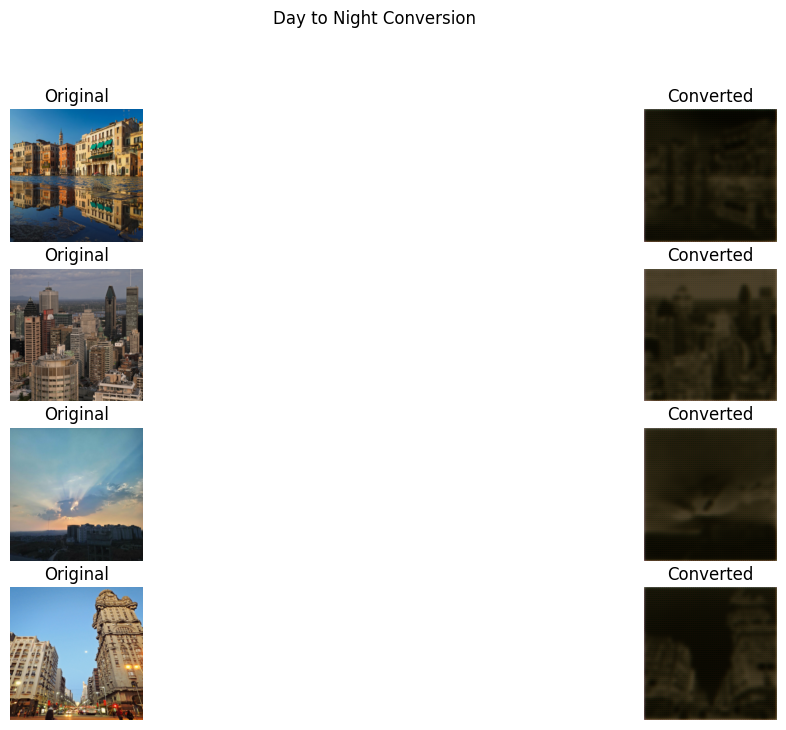

Displaying Night to Day conversions


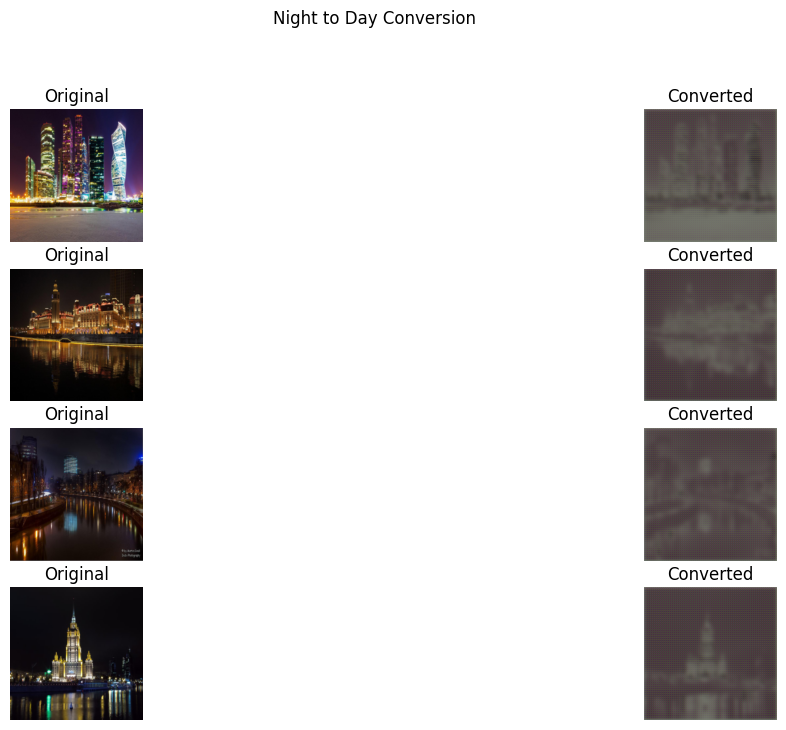

In [ ]:
# Display generated images
import matplotlib.pyplot as plt

def display_generated_images(generator, dataset_loader, title):
    generator.eval()
    with torch.no_grad():
        sample_images = next(iter(dataset_loader)).to(DEVICE)
        plt.figure(figsize=(15, 10))
        for i in range(min(5, sample_images.size(0))):
            img = sample_images[i].cpu().permute(1, 2, 0).numpy()
            img = (img + 1) / 2.0

            generated_img = generator(sample_images[i][None, ...])[0].cpu().permute(1, 2, 0).numpy()
            generated_img = (generated_img + 1) / 2.0

            plt.subplot(5, 2, i * 2 + 1)
            plt.title("Original")
            plt.imshow(img)
            plt.axis('off')

            plt.subplot(5, 2, i * 2 + 2)
            plt.title("Converted")
            plt.imshow(generated_img)
            plt.axis('off')

        plt.suptitle(title)
        plt.show()

print("Displaying Day to Night conversions")
display_generated_images(generator_g, day_loader, "Day to Night Conversion")

print("Displaying Night to Day conversions")
display_generated_images(generator_f, night_loader, "Night to Day Conversion")


In [ ]:
torch.save(generator_g.state_dict(), "generator_g.pth")
torch.save(generator_f.state_dict(), "generator_f.pth")
torch.save(discriminator_x.state_dict(), "discriminator_x.pth")
torch.save(discriminator_y.state_dict(), "discriminator_y.pth")


In [ ]:
from google.colab import files

files.download("generator_g.pth")
files.download("generator_f.pth")
files.download("discriminator_x.pth")
files.download("discriminator_y.pth")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>